# Physics Informed Neural Network (PINN) Examples

The example problem we solve here is the 1D damped harmonic oscillator:
$$
m \dfrac{d^2 x}{d t^2} + \mu \dfrac{d x}{d t} + kx = 0~,
$$
with the initial conditions
    $$ x(0) = 1~~,~~\dfrac{d x}{d t} = 0~. $$
In the case of under-damped state, i.e. $\delta < \omega_0$, with $\delta = \mu\,/\,2m$ and $\omega=\sqrt{\omega_0^2 - \delta^2}$) the exact solution is : $ x(t) = e^{-\delta t}(2 A \cos(\phi + \omega t))$


In [196]:
import numpy as np
import torch
import matplotlib.pyplot as plt

from glob import glob
from tqdm import tqdm

from utils import create_gif, plot_result

## Generate training data

> First, we generate some training data from a small part of the true analytical solution.

Define the exact solution of the harmonic oscillation

In [197]:
def oscillator(d, w0, x):
    """Defines the analytical solution from: https://beltoforion.de/en/harmonic_oscillator/"""
    assert d < w0
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*x)
    sin = torch.sin(phi+w*x)
    exp = torch.exp(-d*x)
    y  = exp*2*A*cos
    return y

For this problem, we use, $\delta=2$, $\omega_0=20$, and try to learn the solution over the domain $x\in [0,1]$.

torch.Size([500, 1]) torch.Size([500, 1])
torch.Size([10, 1]) torch.Size([10, 1])


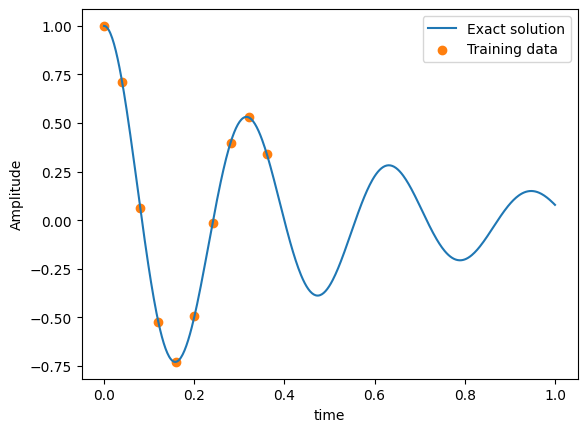

In [198]:
d, w0 = 2, 20
m = 1
mu, k = 2*m*d, m*w0**2

# get the analytical solution over the full domain
x = torch.linspace(0, 1, 500).view(-1,1)
y = oscillator(d, w0, x).view(-1,1)
print(x.shape, y.shape)

# slice out a small number of points
x_data = x[0:200:20]
y_data = y[0:200:20]
print(x_data.shape, y_data.shape)

plt.plot(x, y, label="Exact solution")
plt.scatter(x_data, y_data, color="tab:orange", label="Training data")
plt.xlabel('time'), plt.ylabel('Amplitude')
plt.legend()
plt.show()

## Normal neural network
> Train a standard neural network to interpolate a small part of the solution, using incomplete training points.

Define a simple fully connected neural network (FCNN) in `pytorch`.

In [199]:
class FCN(torch.nn.Module):
    "Defines a connected network"
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = torch.nn.Tanh
        self.fcs = torch.nn.Sequential(*[torch.nn.Linear(N_INPUT, N_HIDDEN), activation()])
        self.fch = torch.nn.Sequential(*[torch.nn.Sequential(*[torch.nn.Linear(N_HIDDEN, N_HIDDEN),activation()]) for _ in range(N_LAYERS-1)])
        self.fce = torch.nn.Linear(N_HIDDEN, N_OUTPUT)
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

Next, we train a standard neural network (fully connected network) to fit these training points. We find that the network is able to fit the solution very closely in the vicinity of the training points, but does not learn an accurate solution outside of them.

In [200]:
# train standard neural network to fit training data
torch.manual_seed(123)

# define the model and optimizer
model = FCN(N_INPUT=1, N_OUTPUT=1, N_HIDDEN=32, N_LAYERS=3)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [201]:
epochs = 1000

files = []
for i in tqdm(range(epochs)):
    # Setting the gradient attribute of each weight to zero
    optimizer.zero_grad()
    
    # train the data on the small sample of point
    yh = model(x_data)
    
    # define a loss function (here: mean squared error)
    loss = torch.mean((yh-y_data)**2)
    
    # Computing the gradient
    loss.backward()
    
    # Adjusting the weights using Adam
    optimizer.step()
    
    # save a plot as training progresses
    if (i%10 == 0): 
        # get a prediciton on the full domain
        yh = model(x).detach()
        
        # plot and save the prediction
        plot_result(x=x, y=y, x_data=x_data, y_data=y_data, yh=yh, i=i)
        fname = './img/nn_%d.png' %i
        plt.savefig(fname, bbox_inches='tight', facecolor="white")
        files.append(fname)
        plt.close()

100%|██████████| 1000/1000 [00:16<00:00, 61.87it/s]


Create a gif from the created images

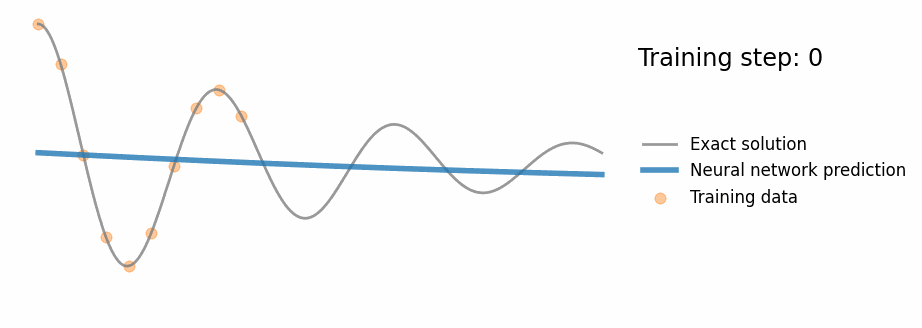

In [202]:
create_gif('nn.gif', files, fps=20, loop=0)

from IPython.display import Image
Image(filename='nn.gif')

## PINN

> Train a PINN to extrapolate the full solution outside of these training points by penalising the underlying differential equation in its loss function.

The physics loss aims to ensure that the learned solution is consistent with the underlying differential equation. 

We can calculate the derivatives of the network solution with respect to its input variable at these points using `pytorch` differentiation features <b>autograd</b>, and can then easily compute the residual of the differential equation using these quantities.

In [31]:
# train standard neural network to fit training data
torch.manual_seed(123)

# define the model and optimizer
model = FCN(N_INPUT=1, N_OUTPUT=1, N_HIDDEN=32, N_LAYERS=3)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [203]:
epochs = 20000

# create a sample over the full domain (require gradient for autograd) but smaller
x_physics = torch.linspace(0, 1, 30).view(-1,1).requires_grad_(True)

files = []
for i in tqdm(range(epochs)):
    optimizer.zero_grad()
    
    # compute the "data loss"
    yh = model(x_data)
    
    # compute the "physics loss"
    yhp = model(x_physics)
    
    # compute dy/dx
    dx = torch.autograd.grad(yhp, x_physics, torch.ones_like(yhp), create_graph=True)[0]
    
    # computes d^2y/dx^2
    dx2 = torch.autograd.grad(dx,  x_physics, torch.ones_like(dx),  create_graph=True)[0]

    # compute the data loss
    loss1 = torch.mean((yh-y_data)**2)
    
    # compute the physic loss
    loss_physics = dx2 + mu*dx + k*yhp
    loss2 = (1e-4)*torch.mean(loss_physics**2)
    
    # combine the two loss
    loss = loss1 + loss2
    
    # backpropagate joint loss
    loss.backward()
    
    # Adjusting the weights using Adam
    optimizer.step()
    
    # save a plot as training progresses
    if (i%100 == 0): 
        # get a prediciton on the full domain
        yh = model(x).detach()
        xp = x_physics.detach()

        # plot and save the prediction
        plot_result(x=x, y=y, x_data=x_data, y_data=y_data, yh=yh, xp=xp, i=i)
        fname = './img/pinn_%d.png' %i
        plt.savefig(fname, bbox_inches='tight', facecolor="white")
        files.append(fname)
        plt.close()

100%|██████████| 20000/20000 [01:55<00:00, 172.61it/s]


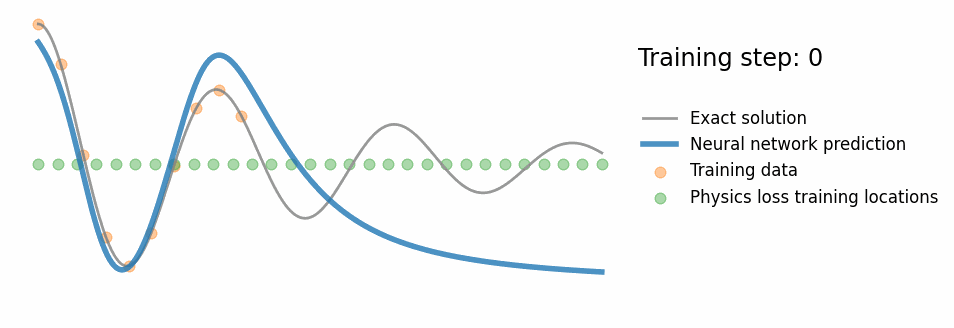

In [204]:
create_gif('pinn.gif', files, fps=20, loop=0)

from IPython.display import Image
Image(filename='pinn.gif')

> Credits: Ben Moseley (ETH)

# Example usage of torch.autograd

Also, quick example of the <b>torch.autograd</b> is a fuction of `pytorch` module that allows you to compute the gradients of specified outputs with respect to certain input tensors.

This function computes and returns the gradients of the specified outputs with respect to the given inputs. It's particularly useful when you need the gradients of some values in your computational graph, and you don't need the gradients with respect to the entire graph.

Here's a basic example to illustrate its usage:

In [205]:
# Create input tensor x and parameters a, b
x = torch.tensor([2.0], requires_grad=True)
a = torch.tensor([3.0], requires_grad=True)
b = torch.tensor([4.0], requires_grad=True)

# Define a simple function
y = a * x**2 + b

# Compute gradients of y with respect to x, a, b
gradients = torch.autograd.grad(y, [x, a, b])

# Gradient with respect to x
dydx = gradients[0]
print("Gradient of y with respect to x:", dydx)  

# Gradient with respect to a
dyda = gradients[1]
print("Gradient of y with respect to a:", dyda)  

# Gradient with respect to b
dydb = gradients[2]
print("Gradient of y with respect to b:", gradients[2])

Gradient of y with respect to x: tensor([12.])
Gradient of y with respect to a: tensor([4.])
Gradient of y with respect to b: tensor([1.])


# Practical Exercise
To familiarise with the network with another example.

The size of an ionized volume $V_I=\frac{4\pi}{3} r^3_I$ around an ionizing source follows:
$$ n_H\,\frac{dV_I}{dt} = \dot{N}_\gamma - n_H^2\,C \,\alpha_B\,V_I$$

which has an exact solution:

$$ r_I(t) = r_S\left(1-e^{-t/t_{rec}}\right)$$

where the two constant term are the equilibrium radius: $r_S = \left(\frac{3 \dot{N}_\gamma}{4\pi\alpha_Bn_H^2} \right)$ and the recombination time: $t_{rec} = \frac{1}{\alpha_B n_H}$

In [262]:
import astropy.units as u
import astropy.constants as cst

In [263]:
def r_I(t):
    dotNgamma = 1e54 / u.s
    nH = 1.87e-4 / u.cm**3
    alpha_B = 2.59e-13 * u.cm**3/u.s
    C = 5

    rS = ((3*dotNgamma/(4*np.pi*alpha_B*C*nH*nH))**(1./3)).to(u.kpc)
    trec = (1./(C*alpha_B*nH)).to(u.Myr)
    print(rS, trec)
    return rS*(1-np.exp(-t/trec))**(1./3)

564.0300697516011 kpc 130.85329347357774 Myr


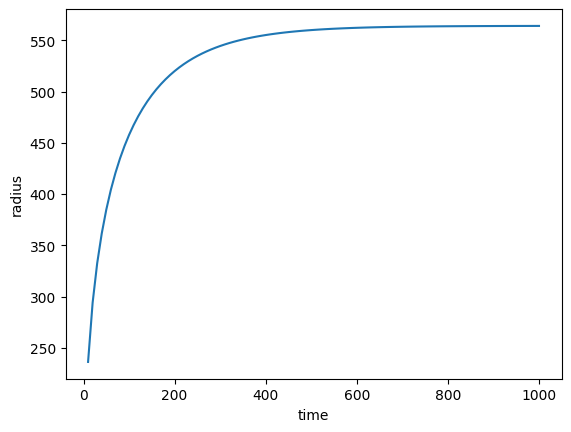

In [264]:
# define a time and calculate the exact solution
time = np.linspace(10, 1000, 100) * u.Myr
r_ion = r_I(time)

plt.plot(time.value, r_ion.value)
plt.ylabel(r'radius'), plt.xlabel('time');


## Generate Training Data

In [265]:
V_ion = (4 * np.pi) / 3 * r_ion**3 / 1e9    # last term for numerical stability

time = torch.tensor(time.value, dtype=torch.float32).view(-1,1)              
V_ion = torch.tensor(V_ion.value, dtype=torch.float32).view(-1,1)

x_data = time[0:30:5]
y_data = V_ion[0:30:5]

x_physics = torch.linspace(torch.min(time), torch.max(time), 30).view(-1,1).requires_grad_(True)

## Training Functions

In [266]:
def compute_physics_loss(yhp, x_physics):
   coef = 1e-54

   dotNgamma = (1e54 / u.s).value
   nH = (1.87e-4 / u.cm**3).value
   alpha_B = (2.59e-13 * u.cm**3/u.s).value
   C = 5

   dv = torch.autograd.grad(yhp, x_physics, torch.ones_like(yhp), create_graph=True)[0]
   
   mod_ode = coef * nH * dv - coef * dotNgamma + coef * nH**2 * C * alpha_B * yhp
   return torch.mean(mod_ode**2)

In [267]:
def train_loop(model, optimizer, epochs, x, y, x_data, y_data, files, x_physics = None):
    for i in tqdm(range(epochs)):
        optimizer.zero_grad()
        
        # compute the "data loss"
        yh = model(x_data)

        # compute the data loss
        loss = torch.mean((yh-y_data)**2)
        
        if(x_physics is not None):
            # compute the "physics loss"
            yhp = model(x_physics)

            # compute the physics loss
            loss_ph = (1e-4) * compute_physics_loss(yhp, x_physics)

            # update loss 
            loss += loss_ph 
        
        if(i % 500 == 0):
            print(loss)

        # backpropagate joint loss
        loss.backward()
        
        # Adjusting the weights using Adam
        optimizer.step()
        
        # save a plot as training progresses
        if (i%100 == 0): 
            # get a prediciton on the full domain
            yh = model(x).detach()

            # plot and save the prediction
            if(x_physics is not None):
                xp = x_physics.detach()
                plot_result(x=x, y=y, x_data=x_data, y_data=y_data, yh=yh, xp=xp, i=i)
                fname = './img/nn2_%d.png' %i
            else:
                plot_result(x=x, y=y, x_data=x_data, y_data=y_data, yh=yh, i=i)
                fname = './img/pinn2_%d.png' %i
            plt.savefig(fname, bbox_inches='tight', facecolor="white")
            files.append(fname)
            plt.close()

## Normal NN

In [268]:
# train standard neural network to fit training data
torch.manual_seed(123)

# define the model and optimizer
model = FCN(N_INPUT=1, N_OUTPUT=1, N_HIDDEN=32, N_LAYERS=3)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

In [269]:
epochs = 1000

files = []

train_loop(model, optimizer, epochs, time, V_ion, x_data, y_data, files)

  0%|          | 1/1000 [00:00<01:49,  9.08it/s]

tensor(0.5327, grad_fn=<MeanBackward0>)


 59%|█████▉    | 589/1000 [00:01<00:00, 513.14it/s]

tensor(3.2951e-05, grad_fn=<MeanBackward0>)


100%|██████████| 1000/1000 [00:02<00:00, 443.89it/s]


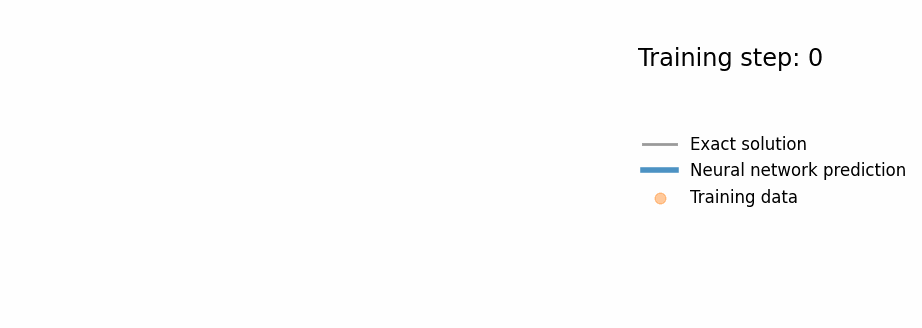

In [270]:
create_gif('nn2.gif', files, fps=20, loop=0)

from IPython.display import Image
Image(filename='nn2.gif')

## PINN

In [271]:
# train physics-informed neural network to fit training data
torch.manual_seed(123)

# define model and loss
model = FCN(N_INPUT=1, N_OUTPUT=1, N_HIDDEN=32, N_LAYERS=3)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

In [272]:
epochs = 20000

files = []

train_loop(model, optimizer, epochs, time, V_ion, x_data, y_data, files, x_physics)

  0%|          | 1/20000 [00:00<45:04,  7.39it/s]

tensor(0.5328, grad_fn=<AddBackward0>)


  3%|▎         | 519/20000 [00:01<01:05, 298.09it/s]

tensor(0.0001, grad_fn=<AddBackward0>)


  5%|▌         | 1004/20000 [00:03<01:03, 301.42it/s]

tensor(0.0001, grad_fn=<AddBackward0>)


  8%|▊         | 1501/20000 [00:05<00:59, 309.63it/s]

tensor(0.0002, grad_fn=<AddBackward0>)


 10%|█         | 2001/20000 [00:06<00:55, 323.67it/s]

tensor(0.0005, grad_fn=<AddBackward0>)


 13%|█▎        | 2532/20000 [00:08<00:59, 295.01it/s]

tensor(0.0002, grad_fn=<AddBackward0>)


 15%|█▌        | 3001/20000 [00:09<00:52, 320.96it/s]

tensor(0.0001, grad_fn=<AddBackward0>)


 17%|█▋        | 3482/20000 [00:12<01:14, 222.94it/s]

tensor(0.0001, grad_fn=<AddBackward0>)


 20%|██        | 4011/20000 [00:15<01:29, 179.60it/s]

tensor(0.0002, grad_fn=<AddBackward0>)


 23%|██▎       | 4501/20000 [00:17<01:22, 187.40it/s]

tensor(0.0001, grad_fn=<AddBackward0>)


 25%|██▌       | 5001/20000 [00:20<01:21, 184.75it/s]

tensor(0.0001, grad_fn=<AddBackward0>)


 27%|██▋       | 5496/20000 [00:22<00:53, 271.09it/s]

tensor(0.0001, grad_fn=<AddBackward0>)


 30%|███       | 6006/20000 [00:24<01:18, 177.40it/s]

tensor(0.0001, grad_fn=<AddBackward0>)


 33%|███▎      | 6501/20000 [00:26<01:06, 201.71it/s]

tensor(0.0001, grad_fn=<AddBackward0>)


 35%|███▌      | 7011/20000 [00:29<01:11, 181.68it/s]

tensor(0.0148, grad_fn=<AddBackward0>)


 37%|███▋      | 7496/20000 [00:31<00:44, 279.45it/s]

tensor(0.0148, grad_fn=<AddBackward0>)


 40%|███▉      | 7995/20000 [00:33<00:45, 265.55it/s]

tensor(0.0148, grad_fn=<AddBackward0>)


 43%|████▎     | 8509/20000 [00:35<00:57, 198.75it/s]

tensor(0.0148, grad_fn=<AddBackward0>)


 45%|████▌     | 9004/20000 [00:37<00:52, 207.89it/s]

tensor(0.0148, grad_fn=<AddBackward0>)


 48%|████▊     | 9503/20000 [00:40<01:00, 173.56it/s]

tensor(0.0148, grad_fn=<AddBackward0>)


 50%|████▉     | 9996/20000 [00:42<00:39, 255.61it/s]

tensor(0.0148, grad_fn=<AddBackward0>)


 52%|█████▎    | 10500/20000 [00:44<00:30, 310.43it/s]

tensor(0.0148, grad_fn=<AddBackward0>)


 55%|█████▌    | 11004/20000 [00:46<00:37, 238.68it/s]

tensor(0.0148, grad_fn=<AddBackward0>)


 58%|█████▊    | 11521/20000 [00:48<00:34, 246.90it/s]

tensor(0.0148, grad_fn=<AddBackward0>)


 60%|██████    | 12020/20000 [00:50<00:33, 237.29it/s]

tensor(0.0148, grad_fn=<AddBackward0>)


 63%|██████▎   | 12501/20000 [00:52<00:31, 237.83it/s]

tensor(0.0148, grad_fn=<AddBackward0>)


 65%|██████▌   | 13012/20000 [00:54<00:30, 226.81it/s]

tensor(0.0148, grad_fn=<AddBackward0>)


 68%|██████▊   | 13501/20000 [00:55<00:26, 248.87it/s]

tensor(0.0148, grad_fn=<AddBackward0>)


 70%|███████   | 14001/20000 [00:57<00:25, 232.87it/s]

tensor(0.0148, grad_fn=<AddBackward0>)


 73%|███████▎  | 14513/20000 [00:59<00:22, 240.25it/s]

tensor(0.0148, grad_fn=<AddBackward0>)


 75%|███████▌  | 15005/20000 [01:01<00:22, 220.74it/s]

tensor(0.0148, grad_fn=<AddBackward0>)


 78%|███████▊  | 15501/20000 [01:03<00:20, 223.59it/s]

tensor(0.0148, grad_fn=<AddBackward0>)


 80%|████████  | 16014/20000 [01:05<00:19, 204.30it/s]

tensor(0.0148, grad_fn=<AddBackward0>)


 83%|████████▎ | 16523/20000 [01:07<00:14, 237.47it/s]

tensor(0.0148, grad_fn=<AddBackward0>)


 85%|████████▌ | 17022/20000 [01:09<00:13, 227.55it/s]

tensor(0.0148, grad_fn=<AddBackward0>)


 88%|████████▊ | 17520/20000 [01:12<00:10, 236.92it/s]

tensor(0.0148, grad_fn=<AddBackward0>)


 90%|█████████ | 18014/20000 [01:14<00:08, 226.20it/s]

tensor(0.0148, grad_fn=<AddBackward0>)


 93%|█████████▎| 18504/20000 [01:15<00:06, 222.76it/s]

tensor(0.0148, grad_fn=<AddBackward0>)


 95%|█████████▍| 18979/20000 [01:17<00:03, 280.31it/s]

tensor(0.0148, grad_fn=<AddBackward0>)


 98%|█████████▊| 19501/20000 [01:20<00:02, 222.77it/s]

tensor(0.0167, grad_fn=<AddBackward0>)


100%|██████████| 20000/20000 [01:21<00:00, 243.98it/s]


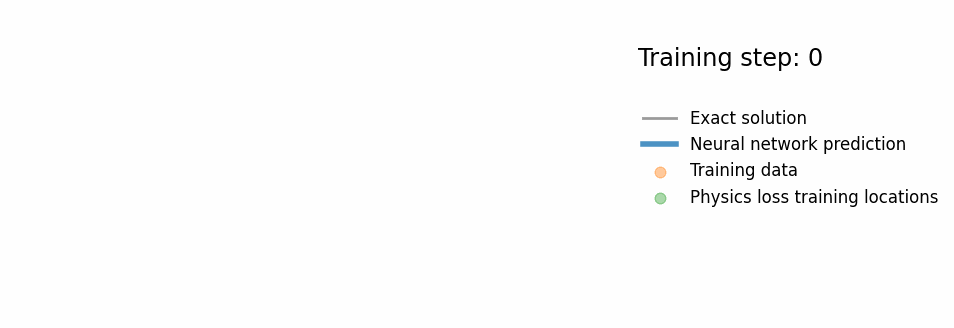

In [259]:
create_gif('pinn2.gif', files, fps=20, loop=0)

from IPython.display import Image
Image(filename='pinn2.gif')